In [10]:
pip install lime

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import json
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.models import resnet18  # Example model, replace with your binary classification model
import torchvision.transforms as T
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [14]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load your EfficientNet-B0 model
model = torch.load('./models/EfficientNetB0/efficientNetB0.pth')  # Assuming binary classification
model = model.eval().to(device)

In [21]:
# Function to preprocess image for EfficientNet model
def pil_to_torch(img):
    transf = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transf(img).unsqueeze(0)

# Utility function to resize and center crop image
def pil_transform(img):
    transf = T.Compose([
        T.Resize((224, 224)),
        T.CenterCrop(224)
    ])
    return transf(img)

# Function to predict probabilities using the model
def cnn_predict(images):
    transf = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    batch = torch.stack(tuple(transf(img) for img in images), dim=0)
    logits = model(batch.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

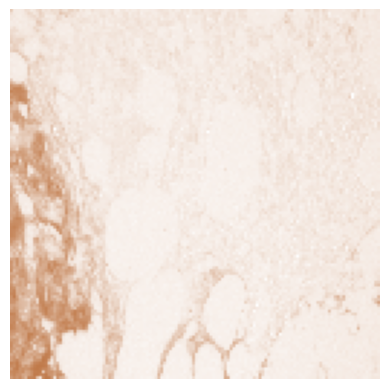

In [29]:
img_file_name = "./Dataset/CANCER/10389 (19).png"  # Replace with your image filename
img_pil = Image.open(img_file_name).convert('RGB')
_ = plt.imshow(img_pil)
plt.axis('off')
plt.show()

In [30]:
explainer = lime_image.LimeImageExplainer()

# Explain the instance
explanation = explainer.explain_instance(np.array(pil_transform(img_pil)),
                                         cnn_predict,
                                         top_labels=2,  # Number of top labels to explain
                                         hide_color=0,
                                         num_samples=1000)

100%|██████████| 1000/1000 [01:01<00:00, 16.17it/s]


ValueError: Positive_only and negative_only cannot be true at the same time.

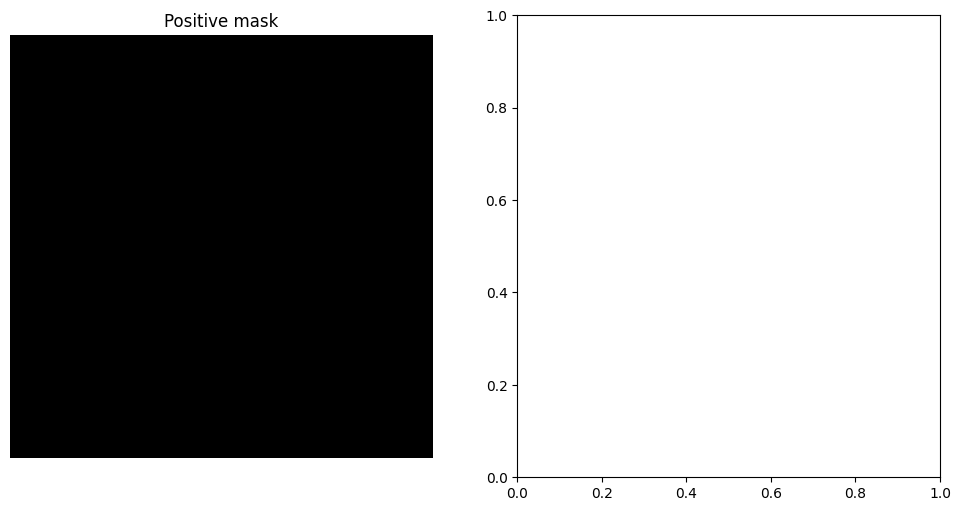

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize positive mask
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry = mark_boundaries(temp / 255.0, mask)
axes[0].imshow(img_boundry)
axes[0].set_title("Positive mask")
axes[0].axis('off')

# Visualize negative mask
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], negative_only=True, num_features=5, hide_rest=True)
img_boundry = mark_boundaries(temp / 255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Negative mask")
axes[1].axis('off')

plt.show()

ValueError: Positive_only and negative_only cannot be true at the same time.

In [64]:
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define device (CPU or GPU)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load your pre-trained EfficientNet_B0 model
model = models.efficientnet_b0(pretrained=True)
model.eval().to(device)

# Define image preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')  # Ensure RGB conversion
    img_tensor = transform(image)
    
    # Convert to numpy array and remove potential alpha channel (if present)
    img_array = img_tensor.squeeze().numpy().transpose((1, 2, 0))  # Move channels to last dimension
    if img_array.shape[-1] > 3:
        img_array = img_array[:, :, :3]  # Select only the first 3 channels (RGB)
    
    return img_array
# Function to predict with EfficientNet_B0 (assuming binary classification)
def predict_for_lime(images):
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.sigmoid(outputs).squeeze()  # Assuming sigmoid output for binary classification
    return probabilities.cpu().numpy()

In [65]:
# Create LIME explainer for image classification
explainer = lime_image.LimeImageExplainer()

In [66]:
def explain_image(image_path, top_labels=1, num_samples=1000):
    """
    Explanation function for an image using LIME on EfficientNet_B0

    Args:
        image_path (str): Path to the image file
        top_labels (int, optional): Number of top labels to explain (default: 1)
        num_samples (int, optional): Number of images to sample for explanation (default: 1000)

    Returns:
        explanation: LIME explanation object
    """

    img = preprocess_image(image_path)
    explanation = explainer.explain_instance(
        img, predict_for_lime, top_labels=top_labels, num_samples=num_samples
    )
    return explanation

In [67]:

# Example usage: explain an image
image_path = "./Dataset/CANCER/10389 (14).png"  # Replace with your image path
explanation = explain_image(image_path)


  1%|          | 9/1000 [00:00<00:07, 140.38it/s]


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [ ]:

# Visualize explanation (modify based on your preference)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)
img_boundary = mark_boundaries(temp / 255.0, mask)

plt.imshow(img_boundary)
plt.title(f"Explanation for label: {explanation.top_labels[0]}")
plt.axis("off")
plt.show()

In [69]:
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define device (CPU or GPU)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load your pre-trained EfficientNet_B0 model
model = torch.load('./models/EfficientNetB0/efficientNetB0.pth')
model.eval().to(device)

# Define image preprocessing function (avoiding unnecessary GPU transfer if not using GPU)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')  # Ensure RGB conversion
    
    img_tensor = transform(image)
    img_tensor = torch.from_numpy(img_tensor)
    # Move to CPU only if on GPU (avoid unnecessary transfer)
    if torch.cuda.is_available():
        img_tensor = img_tensor.cpu()

    return img_tensor.squeeze().numpy().transpose((1, 2, 0))  # Move channels to last dimension

# Function to predict with EfficientNet_B0 (assuming binary classification)
def predict_for_lime(images):
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.sigmoid(outputs).squeeze()  # Assuming sigmoid output for binary classification
    return probabilities.cpu().numpy()

# Create LIME explainer for image classification
explainer = lime_image.LimeImageExplainer()

def explain_image(image_path, top_labels=1, num_samples=1000):
    """
    Explanation function for an image using LIME on EfficientNet_B0

    Args:
        image_path (str): Path to the image file
        top_labels (int, optional): Number of top labels to explain (default: 1)
        num_samples (int, optional): Number of images to sample for explanation (default: 1000)

    Returns:
        explanation: LIME explanation object
    """

    img = preprocess_image(image_path)
    explanation = explainer.explain_instance(
        img, predict_for_lime, top_labels=top_labels, num_samples=num_samples
    )
    return explanation

# Example usage: explain an image
image_path = "./Dataset/CANCER/10389 (14).png"  # Replace with your image path
explanation = explain_image(image_path)

# Visualize explanation (modify based on your preference)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)
img_boundary = mark_boundaries(temp / 255.0, mask)

plt.imshow(img_boundary)
plt.title(f"Explanation for label: {explanation.top_labels[0]}")
plt.axis("off")
plt.show()

TypeError: expected np.ndarray (got Tensor)